# Deep Learning Final Project: Machine Translation with Attention for Chinese-to-English
>[ 專案題目 ]： “Machine Translation with Attention for Chinese-to-English” <br>
[ 專案內容 ]： 參考 [Ref 1: Neural machine translation with attention]。<br>
在 Kaggle 或 Google Colab 完成下列工作：<br>
(1) 利用 Attention models 以及 Anki 訓練資料集: Mandarin Chinese-English cmn-eng.zip <br>
[Ref. 2]，建立一個 中文對英文的機器翻譯模型。 <br>
(2) 請利用該模型翻譯五句中文句子，檢查並比較其輸出結果，做出結論 (Conclusion)。 <br>
<註記> : 此資料集為簡體中文對照英文
-------------------------
[ REFERENCE ]:
1. TensorFlow -“Neural machine translation with attention”
https://www.tensorflow.org/text/tutorials/nmt_with_attention
2. Tab-delimited Bilingual Sentence Pairs -“Mandarin Chinese-English cmn-eng.zip”,
https://www.manythings.org/anki/
3. TensorFlow -“Neural machine translation with a Transformer and Keras”
https://www.tensorflow.org/text/tutorials/transformer

## **Setup**

In [ ]:
!pip3 install tensorflow-text
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 149.7 kB/s eta 0:00:00


In [ ]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [ ]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## **The Data**

In [ ]:
# Load the Drive helper and mount

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# download the file
# the file has lots of noises

from pathlib import Path

!ls "/content/drive/My Drive/Colab Notebooks/cmn-eng/cmn.txt"

INPUT_PATH = "/content/drive/My Drive/Colab Notebooks/cmn-eng/cmn.txt"

path_to_file = Path(INPUT_PATH)

'/content/drive/My Drive/Colab Notebooks/cmn-eng/cmn.txt'


In [ ]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  words = [line.split('\t') for line in lines]

  context = np.array([context for target, context, CCBY in words])
  target = np.array([target for target, context, CCBY in words])

  return target, context

In [ ]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])

如果一個人在成人前沒有機會習得目標語言，他對該語言的認識達到母語者程度的機會是相當小的。


In [ ]:
print(target_raw[-1])

If a person has not had a chance to acquire his target language by the time he's an adult, he's unlikely to be able to reach native speaker level in that language.


## Chinese Word Segmentation
> **Reference**: https://alvinntnu.github.io/NTNU_ENC2045_LECTURES/nlp/chinese-word-seg.html


In [ ]:
! conda activate python-notes
! pip install jieba

/bin/bash: line 1: conda: command not found


In [ ]:
import jieba

def segmentation(text):
  # Split the words
  text = jieba.lcut(text)
  # Change List to String
  text = " ".join(text)
  return text

In [ ]:
example_text = "我已经起来了"
print(segmentation(example_text))

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.430 seconds.
DEBUG:jieba:Loading model cost 1.430 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


我 已经 起来 了


In [ ]:
context_raw = np.array([segmentation(words) for words in context_raw])

In [ ]:
context_raw

array(['嗨 。', '你好 。', '你 用 跑 的 。', ...,
       '你 很 容易 把 母语 说 得 通顺 流畅 ， 却 很 容易 把 非 母语 说 得 不 自然 。',
       '虽然 我 被 公司 解雇 了 ， 但是 我 还 有点 存款 ， 所以 目前 不用 担心 生计 问题 。',
       '如果 一個 人 在 成人 前 沒 有 機會習 得 目標 語言 ， 他 對 該 語言 的 認識 達 到 母語者 程度 的 機會 是 相當 小 的 。'],
      dtype='<U73')

## **Create a tf.data dataset**

In [ ]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [ ]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5],'\n')
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'\xe6\x88\x91 \xe5\xbe\x97 \xe4\xba\x86 \xe9\x87\x8d\xe6\x84\x9f\xe5\x86\x92 \xe3\x80\x82'
 b'\xe6\x88\x91 \xe6\x89\x80 \xe7\x9f\xa5\xe9\x81\x93 \xe7\x9a\x84 \xe6\x98\xaf \xe4\xbb\x96 \xe6\x94\xbe\xe6\xa3\x84 \xe4\xba\x86 \xe9\x80\x99\xe5\x80\x8b \xe8\xa8\x88\xe5\x8a\x83 \xe3\x80\x82'
 b'\xe4\xbb\x96 \xe5\x96\x9c\xe6\xac\xa2 \xe6\x97\x85\xe8\xa1\x8c \xe3\x80\x82 \xe6\x88\x91 \xe4\xb9\x9f \xe6\x98\xaf \xe3\x80\x82'
 b'\xe7\x94\xb1\xe4\xba\x8e \xe9\x94\x99\xe8\xbf\x87 \xe4\xba\x86 \xe7\x81\xab\xe8\xbd\xa6 \xef\xbc\x8c \xe6\x88\x91 \xe4\xb8\x8d\xe5\xbe\x97\xe4\xb8\x8d \xe7\xad\x89 \xe4\xb8\x8b \xe4\xb8\x80\xe7\x8f\xad \xe7\xad\x89 \xe4\xb8\x80 \xe5\xb0\x8f\xe6\x97\xb6 \xe3\x80\x82'
 b'\xe6\x80\x8e\xe4\xb9\x88 \xe5\x8f\xaf\xe8\x83\xbd \xe5\x9c\xa8 \xe6\x88\x91 \xe4\xb8\x8d \xe7\x9f\xa5\xe9\x81\x93 \xe7\x9a\x84 \xe6\x83\x85\xe5\x86\xb5 \xe4\xb8\x8b \xe5\x81\x9a \xe5\xae\x8c \xe5\x91\xa2 \xef\xbc\x9f'], shape=(5,), dtype=string) 

tf.Tensor(
[b"I've caught a bad cold."
 b'All th

## **Text preprocessing**




In [ ]:
# Chinese
def cmn_text_preprocess(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
# English
def eng_text_preprocess(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
# Text Vectorization for Chinese
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=cmn_text_preprocess,
    max_tokens=max_vocab_size,
    ragged=True)

In [ ]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '。', '我', '的', '了', '你', '?']

In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=eng_text_preprocess,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'a']

In [ ]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 5, 63, 7, 2777, 4, 3],
 [2, 5, 295, 26, 6, 12, 10, 1688, 7, 51, 524, 4, 3],
 [2, 10, 50, 294, 4, 5, 78, 12, 4, 3]]>

In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] 我 得 了 重感冒 。 [END]'

Text(0.5, 1.0, 'Mask')

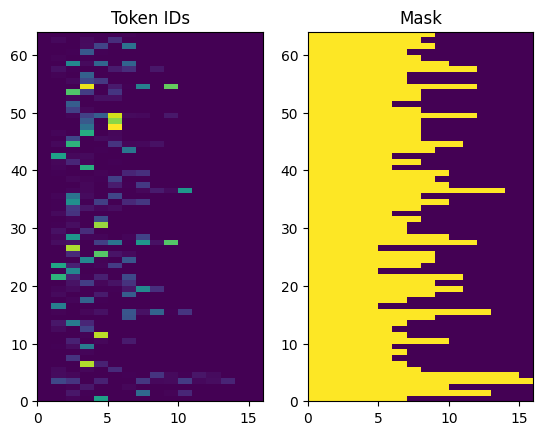

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

## Process the dataset

In [ ]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [ ]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())

[   2 1601    1  133   72 1458 1195    7   18 1978]

[   2    5  863   71    9  868 3733   30    5 1836]
[   5  863   71    9  868 3733   30    5 1836    4]


## The encoder

In [ ]:
UNITS = 256
# UNITS = 512

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                    # Return the sequence and state
                     return_sequences=True,
                     recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [ ]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 14)
Encoder output, shape (batch, s, units): (64, 14, 256)


## The attention layer

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 14, 256)
Target sequence, shape (batch, t, units): (64, 15, 256)
Attention result, shape (batch, t, units): (64, 15, 256)
Attention weights, shape (batch, t, s):    (64, 15, 14)


In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.0000001 , 1.0000001 , 1.        , 1.        ,
       1.        , 1.0000001 , 0.99999994, 1.0000001 , 1.        ,
       1.        , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ],
      dtype=float32)

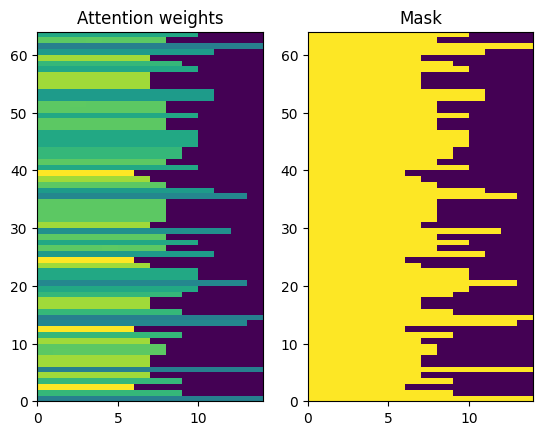

In [ ]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

## The decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                     return_sequences=True,
                     return_state=True,
                     recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 14, 256)
input target tokens shape: (batch, t) (64, 15)
logits shape shape: (batch, target_vocabulary_size) (64, 15, 5000)


In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [ ]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'operation sue rested pastor silly luggage imaginative raised mistaken same',
       b'might alphabet bark common are resigned pretext yellow sushi smartphone',
       b'passengers performance child painful station thou current theme child carved'],
      dtype=object)

## The Model

In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 14)
Target tokens, shape: (batch, t) (64, 15)
logits, shape: (batch, t, target_vocabulary_size) (64, 15, 5000)


## Training

In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
model.compile(optimizer='adam',
       loss=masked_loss,
       metrics=[masked_acc, masked_loss])

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [ ]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 9s 37ms/step - loss: 8.5268 - masked_acc: 1.0040e-04 - masked_loss: 8.5268


{'loss': 8.526769638061523,
 'masked_acc': 0.00010040160123025998,
 'masked_loss': 8.526769638061523}

In [ ]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    # callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/100
100/100 [==============================] - 29s 123ms/step - loss: 5.0940 - masked_acc: 0.2514 - masked_loss: 5.0940 - val_loss: 4.1533 - val_masked_acc: 0.3480 - val_masked_loss: 4.1533
Epoch 2/100
100/100 [==============================] - 5s 53ms/step - loss: 3.8379 - masked_acc: 0.3884 - masked_loss: 3.8379 - val_loss: 3.4814 - val_masked_acc: 0.4208 - val_masked_loss: 3.4814
Epoch 3/100
100/100 [==============================] - 4s 42ms/step - loss: 3.3800 - masked_acc: 0.4350 - masked_loss: 3.3800 - val_loss: 3.1282 - val_masked_acc: 0.4608 - val_masked_loss: 3.1282
Epoch 4/100
100/100 [==============================] - 6s 60ms/step - loss: 2.9955 - masked_acc: 0.4790 - masked_loss: 2.9954 - val_loss: 2.8802 - val_masked_acc: 0.4895 - val_masked_loss: 2.8802
Epoch 5/100
100/100 [==============================] - 4s 39ms/step - loss: 2.5717 - masked_acc: 0.5268 - masked_loss: 2.5717 - val_loss: 2.6488 - val_masked_acc: 0.5221 - val_masked_loss: 2.6488
Epoch 6/100
100/10

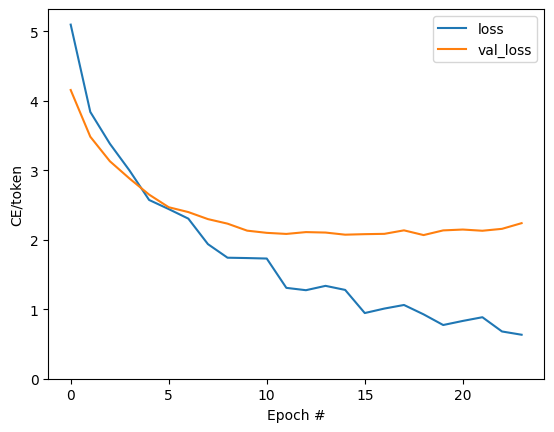

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

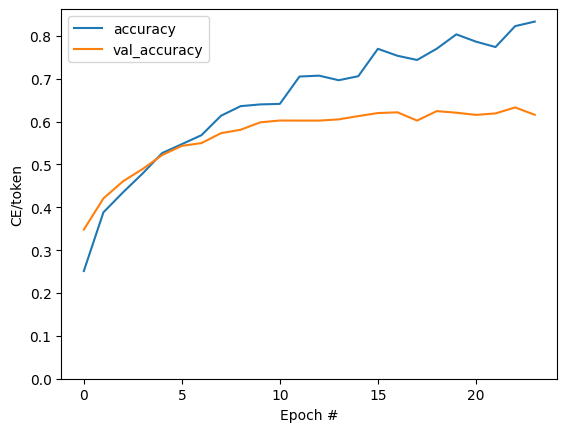

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Translate

In [ ]:
@Translator.add_method
def translate(self,texts, *,max_length=50,temperature=0.0):
  texts = [segmentation(texts)]
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [ ]:
inputs = ['我喜欢你','快!','你确定？','等我一下','请完成数学练习。','明天要不要吃早餐?','如果明天天气很好，要不要出去玩?']

In [ ]:
%%time
for t in inputs:
  print(model.translate(t)[0].numpy().decode())

print()

i like you . 
step on ! 
are you sure about this ? 
i wait for a minute . 
please get out math . 
what will you have to have breakfast tomorrow ? 
if it rains tomorrow , wont you go ? 

CPU times: user 1.74 s, sys: 35.3 ms, total: 1.77 s
Wall time: 1.8 s


## Discussion & Conclusion
若以原本範本的模型設定，model accuarcy 大約為77%，基本上輸入中文單字與簡短的句子皆可以正確翻譯，但隨著句子的字數增加，準確度逐漸降低。我嘗試用以下方式挑整超參數來提高準確度，我首先改變EarlyStopping的Step，從3調整成5，模型的準確度來到了82%，此時正確翻譯的最大長度有效增加。接著我將units從256調整至512，模型準確度持續提升，但在我輸入的5句話中，就有3個是錯的，推估是有overfitting發生所導致。我觀察到的是，比起西班牙文翻譯，中文翻譯難度高很多，第一: 歐洲的語言與美國的整體架構相近、第二: 中文句子中單字與單字間沒有空格、第三: 兩個字拆開與合併意思相差甚遠，例如: 「明天」與 「明 天」，因此我認為針對此模型，資料數增加會是最直接提升準確的辦法。


